### imports

In [1]:
# # for logging 

from comet_ml import Experiment
from pytorch_lightning.loggers import CometLogger
from pytorch_lightning.loggers import TestTubeLogger
from pytorch_lightning.loggers import WandbLogger
import wandb

# For metrics
from pytorch_lightning import metrics

import math
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import io
import torchtext
from torchtext.utils import download_from_url, extract_archive
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import pytorch_lightning as pl
from pytorch_lightning.trainer.trainer import Trainer





from pytorch_lightning.callbacks.early_stopping import EarlyStopping # The EarlyStopping callback can be used to monitor a validation metric and stop the training when no improvement is observed.
"""
    To enable it:

    Import EarlyStopping callback.

    Log the metric you want to monitor using log() method.

    Init the callback, and set monitor to the logged metric of your choice.

    Pass the EarlyStopping callback to the Trainer callbacks flag.
"""

from pytorch_lightning import seed_everything
seed_everything(42)

42

In [2]:
from pytorch_lightning.metrics import Metric
from pytorch_lightning.metrics.utils import _input_format_classification
from sklearn.metrics import classification_report
class MyClassificationReport(Metric):
    def __init__(self,threshold: float = 0.5,compute_on_step: bool = True,dist_sync_on_step: bool = False):
        super().__init__(
            compute_on_step=compute_on_step,
            dist_sync_on_step=dist_sync_on_step,
        )

        self.threshold = threshold
        self.add_state("preds", default=[], dist_reduce_fx=None)
        self.add_state("target", default=[], dist_reduce_fx=None)

        # rank_zero_warn(
        #     'Metric `MyClassificationReport` will save all targets and predictions in buffer.'
        #     ' For large datasets this may lead to large memory footprint.'
        # )

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        preds = preds.cpu()
        target = target.cpu()
        y_hat, y = preds.max(1).indices, target
        assert y_hat.shape == y.shape
        self.preds.append(y_hat)
        self.target.append(y)

    def compute(self):
        preds = torch.cat(self.preds, dim=0)
        target = torch.cat(self.target, dim=0)

In [3]:
from sklearn.model_selection import train_test_split

class AlarmDataset(Dataset):
    def __init__(self,data,seq_len,batch_size):
        self.length = len(data)//seq_len # how much data i have         
        self.data = data
        self.seq_len = seq_len
        self.batch_size = batch_size
       
    def __getitem__(self, index: int):
        x = self.data[index*self.seq_len:(index*self.seq_len)+self.seq_len]
        y = self.data[1+index*self.seq_len:1+(index*self.seq_len)+self.seq_len]
        return x,y
    
    def __len__(self) -> int:
        return self.length

class MyDataModule(pl.LightningDataModule):
    
    def __init__(self,config):
        super().__init__()
        self.config = config
        dir_path = self.config['dir-path']
        file_name = 'train.tokens'

        self.tokenizer = get_tokenizer('basic_english')
        self.vocab = build_vocab_from_iterator(map(self.tokenizer,iter(io.open(dir_path+file_name,encoding="utf8"))))
    

        train_data = self.data_process(iter(io.open(dir_path +"train.tokens", encoding="utf8")))
        val_data = self.data_process(iter(io.open(dir_path +"val.tokens", encoding="utf8")))
        test_data = self.data_process(iter(io.open(dir_path +"test.tokens", encoding="utf8")))

    
        self.train_dataset = AlarmDataset(train_data, self.config['seq-len'], self.config['batch-size'])
        self.valid_dataset = AlarmDataset(val_data,self.config['seq-len'], self.config['batch-size'])
        self.test_dataset = AlarmDataset(test_data, self.config['seq-len'], self.config['batch-size'])

    
    def data_process(self, raw_text_iter):
        data = [torch.tensor([self.vocab[token] for token in self.tokenizer(item)],dtype=torch.long) for item in raw_text_iter]
        return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))
    
    def get_weight_per_class(self):
        def lambdaFun(total,v,num_classes):
            if v>0:
                return total/(v*num_classes) 
            return 0
        
        index_2_count = {self.vocab.stoi[k]:self.vocab.freqs[k]  for k in list(self.vocab.stoi)}
        total = sum(index_2_count.values())
        index_2_ws = {k:lambdaFun(total,v,len(index_2_count)) for k,v in index_2_count.items()}
        index_2_ws[1] = 0.0 # MANUALLY Setting the weights to zero for the padding
        # index_2_ws[0] = 0.0 # MANUALLY Setting the weights to zero for the padding
        ws = torch.tensor([index_2_ws[i] for i in range(len(index_2_ws))])

        return ws

    def prepare_data(self):
        """
            Use this method to do things that might write to disk or that need to be done only from a single GPU in distributed settings.
            e.g., download,tokenize,etc…
        """ 
        return None


    def setup(self, stage: None):
        """
            There are also data operations you might want to perform on every GPU. Use setup to do things like:
            count number of classes,build vocabulary,perform train/val/test splits,apply transforms (defined explicitly in your datamodule or assigned in init),etc…
        """
        return None

    def train_dataloader(self) -> DataLoader:
        return DataLoader(self.train_dataset, batch_size=self.config['batch-size'], shuffle=False,num_workers=8,drop_last=True, pin_memory=True)
    
    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.valid_dataset, batch_size=self.config['batch-size'], shuffle=False,num_workers=8,drop_last=True, pin_memory=True)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.config['batch-size'], shuffle=False,num_workers=8,drop_last=True, pin_memory=True)



In [4]:
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [5]:
class TransformerModel(pl.LightningModule):

    def __init__(self, config):
        super(TransformerModel, self).__init__()
        self.accuraccy_50_count = 0
        self.config = config        
        self.lr = self.config["lr"]
        self.weight_decay = self.config["weight-decay"]
    
        self.pos_encoder = PositionalEncoding(self.config['em-size'], self.config['dropout'])
        encoder_layers = torch.nn.TransformerEncoderLayer(self.config['em-size'], self.config['nhead'], self.config['nhid'], self.config["dropout"])
        self.transformer_encoder = torch.nn.TransformerEncoder(encoder_layers, self.config['nlayers'])
        self.encoder = torch.nn.Embedding(self.config["vocab-size"], self.config['em-size'])
        self.decoder = torch.nn.Linear(self.config['em-size'], self.config["vocab-size"])
        self.src_mask = self.generate_square_subsequent_mask(self.config['seq-len'])
        self.init_weights()

        self.class_weight = self.config['weight_per_class']

        # self.train_F1 = metrics.classification.F1(num_classes=self.config["vocab-size"],average = 'micro')
        # self.val_F1 = metrics.classification.F1(num_classes=self.config["vocab-size"],average = 'micro')
        # self.test_F1 = metrics.classification.F1(num_classes=self.config["vocab-size"],average = 'micro')
        
        self.val_CM_normalized = metrics.classification.ConfusionMatrix(num_classes=self.config["vocab-size"],normalize ='true')
        self.val_CM_raw = metrics.classification.ConfusionMatrix(num_classes=self.config["vocab-size"])

        self.train_CM_normalized = metrics.classification.ConfusionMatrix(num_classes=self.config["vocab-size"],normalize ='true')
        self.train_CM_raw = metrics.classification.ConfusionMatrix(num_classes=self.config["vocab-size"])

        self.test_CM = metrics.classification.ConfusionMatrix(num_classes=self.config["vocab-size"],normalize ='true')

        self.val_MCR = MyClassificationReport()
        self.test_MCR = MyClassificationReport()

        self.log("Sequence length",self.config['seq-len'])
        self.log("lr",self.lr)
        self.log("# of tokens/vocab_size (unique alarms)",self.config['vocab-size'])
        self.log("weight_decay",self.weight_decay)
        self.save_hyperparameters()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src_mask = src_mask.to(self.device)
        src = self.encoder(src) * math.sqrt(self.config['em-size'])
        src = self.pos_encoder(src)
        src_mask = src_mask.to(self.device)
      
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        
        return output

   # The ReduceLROnPlateau scheduler requires a monitor
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,weight_decay=self.weight_decay)
        d = {
       'optimizer': optimizer,
       'lr_scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = "min", factor = 0.5, patience=10, verbose=True),
       'monitor': 'val_epoch_loss',
        'interval': 'epoch'
        }
        return d 

    def loss_function(self,logits,y):
        return F.cross_entropy(logits,y,weight= self.class_weight,ignore_index=1) 

    def myPrintToFile(self,cm_normal,cm_raw,f):
        cm_normal = cm_normal.cpu()
        cm_raw = cm_raw.cpu()
        

        sum_of_each_class = cm_raw.sum(axis=1) # sum along the columns
        print(f"        ------ Epoch {self.current_epoch} ---------",file=f)
        print(f"Total={[v.item() for v in sum_of_each_class]}",file=f)
        print(f"Corret={[v.item() for v in torch.diagonal(cm_raw,0)]}",file=f)
        print(f"Accuracy={[round(v.item(),3) for v in (torch.diagonal(cm_raw,0)/sum_of_each_class)]}",file=f)

        accs = [round(v.item(),3)  for v in torch.diagonal(cm_normal,0)]

        source2acc = {self.config['vocab'].itos[i]:accs[i] for i in range(len(accs))}

        source2_acc50 = {self.config['vocab'].itos[i]:accs[i] for i in range(len(accs)) if accs[i]>=0.5}

        print(f"Acc2={accs}",file=f)
        print(f"source2_acc= {source2acc}",file=f)
        print(f"source2_acc50= {source2_acc50}",file=f)

        a_50 = len([a for a in accs if a>=0.5])
        a_30 = len([a for a in accs if a>=0.3])
        out_str = f"acc>0.5= {a_50}, acc>=0.3= {a_30}, Total={len(accs)}"
        print(out_str,file=f)

        


        # if temp> self.accuraccy_50_count and train=:
        #     self.accuraccy_50_count = temp
        print(out_str,end=" ") 

      

    def training_step(self,batch,batch_idx):
        x,y = batch
        x = x.T
        y = y.T.reshape(-1)

        if x.size(0) != self.config['seq-len']:
           self.src_mask =  self.generate_square_subsequent_mask(x.size(0))
        
        y_hat = self(x,self.src_mask)
        y_hat =  y_hat.view(-1, self.config['vocab-size'])
        loss = self.loss_function(y_hat,y) # cross entropy itself compute softmax 

        self.train_CM_normalized(F.softmax(y_hat),y)
        self.train_CM_raw(F.softmax(y_hat),y)
        
        self.log('train_loss',loss,logger=True)
        # self.log('train_F1',self.train_F1(F.softmax(y_hat),y),logger=True)
        return loss

    def validation_step(self,batch, batch_idx):
        x,y = batch
        x = x.T
        y = y.T.reshape(-1)
        
        if x.size(0) != self.config['seq-len']:
            # print(f">> passed {x.size()}")
            self.src_mask =  self.generate_square_subsequent_mask(x.size(0))
        
        y_hat = self(x,self.src_mask)
        y_hat =  y_hat.view(-1, self.config['vocab-size'])
        loss = self.loss_function(y_hat,y)

        self.val_MCR(F.softmax(y_hat),y)
        self.val_CM_normalized(F.softmax(y_hat),y)
        self.val_CM_raw(F.softmax(y_hat),y)

        self.log('val_loss',loss,logger=True)
        # self.log('val_F1',self.val_F1(F.softmax(y_hat) ,y),logger=True)
        return {'val_loss':loss}
    
    def test_step(self,batch, batch_idx):
        x,y = batch
        x = x.T
        y = y.T.reshape(-1)
        if x.size(0) != self.config['seq-len']:
           self.src_mask =  self.generate_square_subsequent_mask(x.size(0))

        y_hat = self(x,self.src_mask)
        y_hat =  y_hat.view(-1,  self.config['vocab-size'])
        loss = self.loss_function(y_hat,y)

        self.test_MCR(F.softmax(y_hat),y)
        self.log('test_loss',loss,logger=True)
        # self.log('test_F1', self.test_F1(F.softmax(y_hat) ,y),logger=True)
        return {'test_loss':loss}
    
    def training_epoch_end(self, outputs):

        avg_loss = torch.stack([d['loss']  for d in outputs]).mean()
        # f1 = self.train_F1.compute()
        print(f"[{self.current_epoch}]E, Avg Training loss = {round(avg_loss.item(),4)}",end=" ")
        
        with open(self.config["train-file"],'a') as f:
            self.myPrintToFile(self.train_CM_normalized.compute(),self.train_CM_raw.compute(),f)
        self.log("train_epoch_loss",avg_loss,logger=True,prog_bar=True)
        # self.log("train_epoch_F1", f1, logger=True,prog_bar=True)
  
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([d['val_loss'] for d in outputs]).mean()
        # f1 = self.val_F1.compute()
        # print(self.val_MCR.compute(),file=open("val-out.txt",'w'))
        # print(self.val_CM.compute(),file=open("val-cm-out.txt",'w'))

        # if self.current_epoch%4==0 and self.current_epoch>0:
        # self.myPrintToFile(self.val_CM_normalized.compute(),self.val_CM_raw.compute())


        print(f"::Val Loss = {round(avg_loss.item(),4) }",end=" ")

        with open(self.config["val-file"],'a') as f:
            self.myPrintToFile(self.val_CM_normalized.compute(),self.val_CM_raw.compute(),f)
        
        print("")


        self.log("val_epoch_loss",avg_loss,logger=True)
        # self.log("val_epoch_F1",f1,logger=True,prog_bar=True)
    
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([d['test_loss'] for d in outputs]).mean()
        # f1 = self.test_F1.compute()
        # print(self.test_MCR.compute(),file=open("test-out.txt",'w'))
        print(f">Average Test Loss = {avg_loss.item()}")
        self.log("test_epoch_loss",avg_loss, logger = True)
        # self.log("test_epoch_F1",f1, logger=True)
        
    

# Trainning

**Note: When monitoring any parameter after the validation epoch end then you should pass check_val_every_n_epoch=1  not to other. This is very important.**

In [6]:
def weightCondition(w,avg_w):
    if w<avg_w:
        return w
    else:
        return avg_w

# setup data
config_data = {
'dir-path' : "../.data/",
'batch-size' :512, # Batch Size 
'seq-len' :128, # Sequence length
}

dm = MyDataModule(config=config_data)
ws = dm.get_weight_per_class().cuda()

print("Before",[round(w.item(),3) for w in ws])
# avg_w = sum(ws)/len(ws)
# ws = torch.tensor([weightCondition(w,avg_w) for w in ws]).cuda()
print("After",[round(w.item(),3) for w in ws])




config_model = {
    'lr' : 0.001,
    'dropout' : 0.2,
    'weight-decay': 3.1,
    'em-size' :256, # embedding dimension 
    'nhid' : 128, # the dimension of the feedforward network model in nn.TransformerEncoder
    'nlayers' :4, # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    'nhead' : 2, # the number of heads in the multiheadattention models
    'seq-len': config_data['seq-len'], # dont use wandb config 
    'vocab-size':len(dm.vocab.stoi), # the size of vocabulary /also called tokens
    'weight_per_class':ws,
    "val-file":"val-out.txt",
    "train-file":'train-out.txt',
    "vocab": dm.vocab
}

with open (config_model["val-file"],'w') as f:
    f.write(">> Starting")

with open (config_model["train-file"],'w') as f:
    f.write(">> Starting")

# setup model - note how we refer to sweep parameters with wandb.config
model = TransformerModel(config=config_model)


48652lines [00:00, 84705.10lines/s]


Before [0.0, 0.0, 0.008, 0.009, 0.059, 0.061, 0.063, 0.075, 0.075, 0.075, 0.076, 0.078, 0.083, 0.098, 0.101, 0.11, 0.143, 0.157, 0.158, 0.172, 0.176, 0.18, 0.186, 0.187, 0.251, 0.269, 0.31, 0.327, 0.337, 0.344, 0.35, 0.363, 0.371, 0.377, 0.377, 0.389, 0.39, 0.404, 0.418, 0.419, 0.426, 0.428, 0.428, 0.467, 0.47, 0.476, 0.48, 0.48, 0.486, 0.492, 0.495, 0.495, 0.513, 0.531, 0.537, 0.539, 0.546, 0.576, 0.58, 0.601, 0.624, 0.629, 0.63, 0.644, 0.644, 0.654, 0.66, 0.662, 0.667, 0.673, 0.673, 0.687, 0.706, 0.707, 0.708, 0.735, 0.746, 0.749, 0.764, 0.785, 0.802, 0.803, 0.807, 0.827, 0.848, 0.904, 0.905, 0.905, 0.909, 0.911, 0.919, 0.935, 0.966, 0.976, 0.978, 0.982, 0.983, 1.004, 1.013, 1.03, 1.039, 1.05, 1.051, 1.054, 1.081, 1.082, 1.096, 1.109, 1.115, 1.124, 1.14, 1.141, 1.155, 1.16, 1.173, 1.177, 1.188, 1.198, 1.2, 1.201, 1.215, 1.235, 1.24, 1.25, 1.254, 1.254, 1.254, 1.254, 1.254, 1.254, 1.254, 1.254, 1.254, 1.264, 1.279, 1.283, 1.284, 1.303, 1.304, 1.316, 1.333, 1.338, 1.392, 1.398, 1.447, 

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

   | Name                | Type                   | Params
----------------------------------------------------------------
0  | pos_encoder         | PositionalEncoding     | 0     
1  | transformer_encoder | TransformerEncoder     | 1.3 M 
2  | encoder             | Embedding              | 182 K 
3  | decoder             | Linear                 | 183 K 
4  | val_CM_normalized   | ConfusionMatrix        | 0     
5  | val_CM_raw          | ConfusionMatrix        | 0     
6  | train_CM_normalized | ConfusionMatrix        | 0     
7  | train_CM_raw        | ConfusionMatrix        | 0     
8  | test_CM             | ConfusionMatrix        | 0     
9  | val_MCR             | MyClassificationReport | 0     
10 | test_MCR            | MyClassificationReport | 0     
----------------------------------------------------------------
1.7 M     Trainab

::Val Loss = 6.9607 acc>0.5= 1, acc>=0.3= 3, Total=714 
::Val Loss = 6.9858 acc>0.5= 1, acc>=0.3= 2, Total=714 
[0]E, Avg Training loss = 6.9803 acc>0.5= 0, acc>=0.3= 1, Total=714 ::Val Loss = 6.9834 acc>0.5= 1, acc>=0.3= 2, Total=714 
[1]E, Avg Training loss = 6.9755 acc>0.5= 0, acc>=0.3= 1, Total=714 ::Val Loss = 6.9468 acc>0.5= 1, acc>=0.3= 2, Total=714 
[2]E, Avg Training loss = 6.9691 acc>0.5= 0, acc>=0.3= 1, Total=714 ::Val Loss = 6.6258 acc>0.5= 0, acc>=0.3= 2, Total=714 
[3]E, Avg Training loss = 6.8443 acc>0.5= 0, acc>=0.3= 1, Total=714 ::Val Loss = 6.3592 acc>0.5= 5, acc>=0.3= 16, Total=714 
[4]E, Avg Training loss = 6.4388 acc>0.5= 2, acc>=0.3= 4, Total=714 ::Val Loss = 7.4179 acc>0.5= 1, acc>=0.3= 1, Total=714 
[5]E, Avg Training loss = 6.5074 acc>0.5= 0, acc>=0.3= 0, Total=714 [6]E, Avg Training loss = 7.2565 acc>0.5= 0, acc>=0.3= 0, Total=714 Suggested lr = 0.005754399373371567


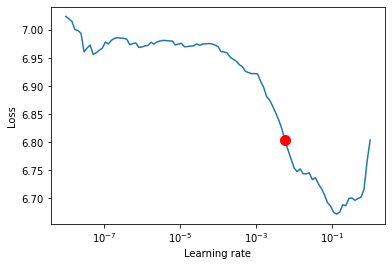

In [7]:
early_stop_callback = EarlyStopping(
        monitor='val_epoch_loss',
        min_delta=0,
        patience=600,
        verbose=True,
        mode='min'
)



trainer = Trainer(auto_lr_find=0.0001, precision=16,gpus=-1, num_nodes=1,  max_epochs=1200, check_val_every_n_epoch=1,deterministic=True,gradient_clip_val=0.5,enable_pl_optimizer=True,callbacks=[early_stop_callback],progress_bar_refresh_rate=0)

# Run learning rate finder
lr_finder = trainer.tuner.lr_find(model,dm)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

print(f"Suggested lr = {new_lr}")

In [8]:
model.hparams.lr = new_lr/100 #7.5e-12 # can devide by 10

# Fit model
trainer.fit(model,dm)



Finding best initial lr: 100%|██████████| 100/100 [00:36<00:00,  2.76it/s]

   | Name                | Type                   | Params
----------------------------------------------------------------
0  | pos_encoder         | PositionalEncoding     | 0     
1  | transformer_encoder | TransformerEncoder     | 1.3 M 
2  | encoder             | Embedding              | 182 K 
3  | decoder             | Linear                 | 183 K 
4  | val_CM_normalized   | ConfusionMatrix        | 0     
5  | val_CM_raw          | ConfusionMatrix        | 0     
6  | train_CM_normalized | ConfusionMatrix        | 0     
7  | train_CM_raw        | ConfusionMatrix        | 0     
8  | test_CM             | ConfusionMatrix        | 0     
9  | val_MCR             | MyClassificationReport | 0     
10 | test_MCR            | MyClassificationReport | 0     
----------------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params


::Val Loss = 6.9607 acc>0.5= 1, acc>=0.3= 3, Total=714 
::Val Loss = 6.6953 acc>0.5= 2, acc>=0.3= 2, Total=714 
[1]E, Avg Training loss = 6.9605 acc>0.5= 0, acc>=0.3= 0, Total=714 ::Val Loss = 6.2927 acc>0.5= 4, acc>=0.3= 18, Total=714 
[2]E, Avg Training loss = 6.5591 acc>0.5= 1, acc>=0.3= 2, Total=714 ::Val Loss = 5.8698 acc>0.5= 26, acc>=0.3= 81, Total=714 
[3]E, Avg Training loss = 5.996 acc>0.5= 14, acc>=0.3= 37, Total=714 ::Val Loss = 5.503 acc>0.5= 59, acc>=0.3= 132, Total=714 
[4]E, Avg Training loss = 5.5356 acc>0.5= 46, acc>=0.3= 119, Total=714 ::Val Loss = 5.2612 acc>0.5= 78, acc>=0.3= 153, Total=714 
[5]E, Avg Training loss = 5.2409 acc>0.5= 80, acc>=0.3= 184, Total=714 ::Val Loss = 5.0282 acc>0.5= 89, acc>=0.3= 171, Total=714 
[6]E, Avg Training loss = 4.9778 acc>0.5= 105, acc>=0.3= 225, Total=714 ::Val Loss = 4.8711 acc>0.5= 104, acc>=0.3= 189, Total=714 
[7]E, Avg Training loss = 4.7696 acc>0.5= 127, acc>=0.3= 244, Total=714 ::Val Loss = 4.694 acc>0.5= 110, acc>=0.3= 198

In [ ]:
trainer.test(datamodule=dm) # testing

## Loggers

In [ ]:
# wandb_logger = WandbLogger(project="Alarm-Transformers-Net")
# comet_logger = CometLogger(
#     api_key="YZWScOiWdE8FwQSUj725dRmor",
#     project_name="Alarm-Transformers-Net" # Optional
# )
# test_tube_logger = TestTubeLogger('tb_logs', name='Alarm-Transformers-Net')

In [ ]:
# early_stop_callback = EarlyStopping(
#    monitor='val_epoch_loss',
#    min_delta=0.00,
#    patience=20,
#    verbose=True,
#    mode='min'
# )

# # setup Trainer
# trainer = Trainer(precision=16,gpus=-1, num_nodes=1,  max_epochs=1, check_val_every_n_epoch=1,deterministic=True, logger=[wandb_logger] ,gradient_clip_val=0.5,enable_pl_optimizer=True,callbacks=[early_stop_callback],progress_bar_refresh_rate=0)
# trainer.fit(model,dm) # traning and validation


# Hyperparameters Configuration
## Hyperparameter optimization with W&B sweeps

So far, we chose our learning rate and number of layers arbitrarily. We can automate hyperparameter search with [W&B sweeps](https://docs.wandb.com/sweeps).

## Defining sweep configuration

Sweeps can be defined in multiple ways:
* with a YAML file - best for distributed sweeps and runs from command line
* with a Python object - best for notebooks


The main items to be defined in a sweep are:
*   **Metric** – This is the metric the sweeps are attempting to optimize. Metrics can take a `name` (this metric should be logged by your training script) and a `goal` (maximize or minimize). 
*   **Search Strategy** – We support several different search strategies with sweeps – `grid`, `random`, `bayes`.
*   **Stopping Criteria** – The strategy for determining when to kill off poorly peforming runs, and try more combinations faster. We offer several custom scheduling algorithms like [HyperBand](https://arxiv.org/pdf/1603.06560.pdf) and Envelope.
*   **Parameters** – A dictionary containing the hyperparameter names, and discreet values, max and min values or distributions from which to pull their values to sweep over.

*Note: you can also use other search libraries such as [Ray-Tune](https://docs.wandb.com/sweeps/ray-tune) or even [create your own search algorithm](https://docs.wandb.com/sweeps/python-api#run-a-local-controller)*

Here we just use a Python object. Refer to the [sweep configuration documentation](https://docs.wandb.com/sweeps/configuration) if you want to define more parameters.

In [ ]:
# sweep_config = {
#   "method": "grid",   # bayes search
#   "metric": {           # We want to minimize validation loss
#       "name": "val_epoch_F1",
#       "goal": "maximize"
#   },
#   "parameters": {
#         "batch-size": {
#             # Choose from pre-defined values
#             "values": [16]
#         },
#         "seq-len": {
#             # Choose from pre-defined values
#             "values": [700,600,400]
#         },
#         "lr": {
#             "values":[0.0001,0.0002,0.0003]
#             # log uniform distribution between exp(min) and exp(max)
#             # "distribution": "log_uniform",
#             # "min": -9.21,   # exp(-9.21) = 1e-4
#             # "max": -4.61    # exp(-4.61) = 1e-2
#         },
#         "dropout":{
#             "values": [0.1,0.15]
#         },
#         "weight-decay":{
#             "values":[0.0003,0.0002,0.00001]
#         },
#         "em-size":{
#             "values":[256,128,64]
#         },
#         "nhid":{
#             "values":[128,64]
#         },
#         "nlayers":{
#             "values":[4,3,2]
#         },
#         "nhead":{
#             "values":[8,4,2]
#         }

#     }
# }

## Running an agent

We now just need to run an agent against the sweep configuration. Sweeps can be run in multiple ways:
* through a command line with `wandb sweep my_sweep_config.yaml`
* directly within a script/notebook with the [Python sweep API](https://docs.wandb.com/sweeps/python-api)

To use the Python sweep API, we define a function that the agent will run, refering to sweep parameters with `wandb.config.my_param`.

In [ ]:


# def sweep_iteration():
#     # set up W&B logger
#     wandb.init()    # required to have access to `wandb.config`
#     wandb_logger = WandbLogger()

#     # setup data
#     config_data = {
#     'batch-size' :wandb.config["batch-size"], # Batch Size 
#     'seq-len' : wandb.config['seq-len'], # Sequence length
#     'filter-seq-len' :350 # remove sequence whose size is greater than this len
#     }

#     dm = MyDataModule(dir_path=dir_name,file_name=fname,config=config_data)


#     config_model = {
#         'lr' : wandb.config['lr'],
#         'dropout' : wandb.config['dropout'],
#         'weight-decay': wandb.config['weight-decay'],
#         'em-size' :wandb.config['em-size'], # embedding dimension 
#         'nhid' : wandb.config['nhid'], # the dimension of the feedforward network model in nn.TransformerEncoder
#         'nlayers' :wandb.config['nlayers'], # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
#         'nhead' : wandb.config['nhead'], # the number of heads in the multiheadattention models
#         'seq-len': config_data['seq-len'], # dont use wandb config 
#         'vocab-size':len(dm.vocab.stoi) # the size of vocabulary /also called tokens
#     }

#     # setup model - note how we refer to sweep parameters with wandb.config
#     model = TransformerModel(config=config_model)

#     # setup Trainer
#     trainer = Trainer(precision=16,gpus=-1, num_nodes=1,  max_epochs=1000, check_val_every_n_epoch=1,deterministic=True, logger=[wandb_logger] ,gradient_clip_val=0.5,enable_pl_optimizer=True,callbacks=[early_stop_callback],progress_bar_refresh_rate=0)
#     trainer.fit(model,dm) # traning and validation

#     return None

# # sweep_id = wandb.sweep(sweep_config, project="Alarm-Transformers-Net") # sweep id based on our configuration
# # wandb.agent(sweep_id, function=sweep_iteration)

### Learning Rate Finder

In [ ]:
# model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout,seq_len=seq_len)
# trainer = Trainer(precision=16,gpus=1,max_epochs=400,check_val_every_n_epoch=4,deterministic=True, gradient_clip_val=0.5,logger=tb_logger,progress_bar_refresh_rate=50,auto_lr_find=0.002)
# trainer.tune(model,dm) # finding the lr : first way
# 2nd way
# lr_finder = trainer.tuner.lr_find(model)
# print(lr_finder.results)
# fig = lr_finder.plot(suggest=True) # Plot with
# fig.show()
# new_lr = lr_finder.suggestion() # Pick point based on plot, or get suggestion



In [ ]:


# config_data = {
#     'batch-size' : 64, # Batch Size 
#     'seq-len' : 900, # Sequence length
#     'filter-seq-len' :350 # remove sequence whose size is greater than this len
# }

# dm = MyDataModule(dir_path=dir_name,file_name=fname,config=config_data)

# config_model = {
#     'lr' : 0.0001,
#     'dropout' : 0.0,
#     'weight-decay': 0.0,
#     'em-size' :256, # embedding dimension 
#     'nhid' : 256, # the dimension of the feedforward network model in nn.TransformerEncoder
#     'nlayers' :2, # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
#     'nhead' : 2, # the number of heads in the multiheadattention models
#     'seq-len': config_data['seq-len'],
#     'vocab-size':len(dm.vocab.stoi) # the size of vocabulary /also called tokens
# }

# print(f"> Vocab Size (Number of Unique Alarms): {config_model['vocab-size']}")
# model = TransformerModel(config=config_model)
# print(f"> Customised lr = {model.lr}")

In [ ]:
# wandb.finish() # When we want to close our W&B run, we can call wandb.finish() (mainly useful in notebooks, called automatically in scripts).
# accelerator='dp'
# progress_bar_refresh_rate=0 # set to zero to disable it

# Ray Tune

In [ ]:
# import shutil
# import tempfile
# from pytorch_lightning.loggers import TensorBoardLogger
# from pytorch_lightning.utilities.cloud_io import load as pl_load
# from ray import tune
# from ray.tune import CLIReporter
# from ray.tune.schedulers import ASHAScheduler, PopulationBasedTraining
# from ray.tune.integration.pytorch_lightning import TuneReportCallback, TuneReportCheckpointCallback


Ray Tune comes with ready-to-use PyTorch Lightning callbacks. To report metrics back to Tune after each validation epoch, we will use the TuneReportCallback:

We are also able to specify the number of epochs to train each model, and the number of GPUs we want to use for training. We also create a TensorBoard logger that writes logfiles directly into Tune’s root trial directory - if we didn’t do that PyTorch Lightning would create subdirectories, and each trial would thus be shown twice in TensorBoard, one time for Tune’s logs, and another time for PyTorch Lightning’s logs.

In [ ]:
# def train_alarmnet_tune(config,num_epochs, dir_name, fname):
#     early_stop_callback = EarlyStopping(
#         monitor='val_epoch_loss',
#         min_delta=0.00,
#         patience=6,
#         verbose=True,
#         mode='min'
#     )

    
#     tuner_callback = TuneReportCallback({
#     "val_epoch_loss": "val_epoch_loss",
#     "val_epoch_F1": "val_epoch_F1"
#     }, on="validation_end")

#     # setup data
#     config_data = {
#     'batch-size' :config["batch-size"], # Batch Size 
#     'seq-len' : config['seq-len'], # Sequence length
#     'filter-seq-len':50 # remove sequence whose size is greater than this len
#     }

#     dm = MyDataModule(dir_path=dir_name,file_name=fname,config=config_data)


#     config_model = {
#         'lr' : config['lr'],
#         'dropout' : config['dropout'],
#         'weight-decay': config['weight-decay'],
#         'em-size' :config['em-size'], # embedding dimension 
#         'nhid' : config['nhid'], # the dimension of the feedforward network model in nn.TransformerEncoder
#         'nlayers' :config['nlayers'], # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
#         'nhead' : config['nhead'], # the number of heads in the multiheadattention models
#         'seq-len': config_data['seq-len'], # dont use wandb config 
#         'vocab-size':len(dm.vocab.stoi), # the size of vocabulary /also called tokens
#         'weight_per_class':ws
#     }

#     # setup model - note how we refer to sweep parameters with wandb.config
#     model = TransformerModel(config=config_model)

#     # setup Trainer
#     # logger=[wandb_logger]
#     tb_logger =  TensorBoardLogger(save_dir=tune.get_trial_dir(), name="", version=".")
#     trainer = Trainer(precision=16,gpus=-1, num_nodes=1,  max_epochs=100, check_val_every_n_epoch=1,deterministic=True, logger = [tb_logger],  gradient_clip_val=0.5,enable_pl_optimizer=True,callbacks=[early_stop_callback,tuner_callback],progress_bar_refresh_rate=0)
#     trainer.fit(model,dm) # traning and validation
#     return None
    

In this example, we use an Asynchronous Hyperband scheduler. This scheduler decides at each iteration which trials are likely to perform badly, and stops these trials. This way we don’t waste any resources on bad hyperparameter configurations.

In [ ]:
# def tune_alarmnet_asha(num_samples, num_epochs, gpus_per_trial=0):
#     dir_name = "/home/waris/Github/predict-future-alarms/.data/"
#     fname = 'seqs.tokens'
#     config_tune = {
#         "batch-size":  tune.choice([32]), 
#         "seq-len": tune.grid_search([16,32,64,128,256]),        
#         "lr": tune.grid_search([0.0001,0.001]),
#         "dropout": tune.grid_search ( [0.1,0.15]),
#         "weight-decay": tune.grid_search([0.0003,0.0002]),
#         "em-size":  tune.grid_search([256,128]),
#         "nhid": tune.grid_search([128]),
#         "nlayers": tune.grid_search([4,3]),
#         "nhead": tune.grid_search([8,4])
#         }

#     scheduler = ASHAScheduler(max_t=num_epochs,grace_period=1,reduction_factor=2)

#     # reporter = CLIReporter(
#     #     parameter_columns=["seq-len","lr","dropout","weight-decay","em-size","nhid","nlayers","nhead"],
#     #     metric_columns=["val_epoch_loss","val_epoch_F1","training_iteration"]
#     # )

#     analysis = tune.run(
#         tune.with_parameters(train_alarmnet_tune,num_epochs=num_epochs,dir_name=dir_name,fname=fname),
#         resources_per_trial={"cpu": 4,"gpu":1},
#         metric="val_epoch_loss",
#         mode="min",
#         config=config_tune,
#         num_samples=num_samples,
#         scheduler=scheduler,
#         # progress_reporter=reporter,
#         name="tune_alarmnet_asha")

#     print("Best hyperparameters found were: ", analysis.best_config)

#     shutil.rmtree(dir_name+"ray-tune")

Ray Tune will now proceed to sample 10 different parameter combinations randomly, train them, and compare their performance afterwards.

In [ ]:
# tune_alarmnet_asha(num_samples=10, num_epochs=500)


# Using Population Based Training to find the best parameters (2nd way)

In [ ]:
# def train_alarmnet_tune_checkpoint(config=None,num_epochs=None,checkpoint_dir=None,dir_name=None, fname=None):
#     early_stop_callback = EarlyStopping(
#         monitor='val_epoch_loss',
#         min_delta=0.00,
#         patience=6,
#         verbose=True,
#         mode='min'
#     )

    
#     # tuner_callback = TuneReportCallback({
#     # "val_epoch_loss": "val_epoch_loss",
#     # "val_epoch_F1": "val_epoch_F1"
#     # }, on="validation_end")

#     tuner_callback = TuneReportCheckpointCallback(
#                 metrics={
#                     "val_epoch_loss": "val_epoch_loss",
#                     "val_epoch_F1": "val_epoch_F1"
#                 },
#                 filename="checkpoint",
#                 on="validation_end")


#     # setup data
#     config_data = {
#     'batch-size' :config["batch-size"], # Batch Size 
#     'seq-len' : config['seq-len'], # Sequence length
#     'filter-seq-len':350 # remove sequence whose size is greater than this len
#     }

#     dm = MyDataModule(dir_path=dir_name,file_name=fname,config=config_data)


#     config_model = {
#         'lr' : config['lr'],
#         'dropout' : config['dropout'],
#         'weight-decay': config['weight-decay'],
#         'em-size' :config['em-size'], # embedding dimension 
#         'nhid' : config['nhid'], # the dimension of the feedforward network model in nn.TransformerEncoder
#         'nlayers' :config['nlayers'], # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
#         'nhead' : config['nhead'], # the number of heads in the multiheadattention models
#         'seq-len': config_data['seq-len'], # dont use wandb config 
#         'vocab-size':len(dm.vocab.stoi) # the size of vocabulary /also called tokens
#     }

#     model = None

#     if checkpoint_dir:
#         print("-----------------------------------------------------------------------------------------")
#         # Currently, this leads to errors:
#         # model = LightningMNISTClassifier.load_from_checkpoint(
#         #     os.path.join(checkpoint, "checkpoint"))
#         # Workaround:
#         ckpt = pl_load(os.path.join(checkpoint_dir, "checkpoint"),map_location=lambda storage, loc: storage)
#         model = TransformerModel._load_model_state(ckpt, config=config_model)
#         trainer.current_epoch = ckpt["epoch"]
#     else:
#         model = TransformerModel(config=config_model)

#     # setup model - note how we refer to sweep parameters with wandb.config
#     # model = TransformerModel(config=config_model)

#     # setup Trainer
#     # logger=[wandb_logger]
#     tb_logger =  TensorBoardLogger(save_dir=tune.get_trial_dir(), name="", version=".")
#     trainer = Trainer(precision=16,gpus=-1, num_nodes=1,  max_epochs=100, check_val_every_n_epoch=1,deterministic=True, logger = [tb_logger],  gradient_clip_val=0.5,enable_pl_optimizer=True,callbacks=[early_stop_callback,tuner_callback],progress_bar_refresh_rate=0)


#     trainer.fit(model,dm) # traning and validation
#     return None
    

In [ ]:
# def tune_alarmnet_pbt(num_samples, num_epochs, gpus_per_trial=0):
#     dir_name = "/home/waris/Github/predict-future-alarms/.data/"
#     fname = 'seqs.tokens'
#     config_tune = {
#         "batch-size": 16, 
#         "seq-len": tune.grid_search([700,600,400]),        
#         "lr": 0.0001,
#         "dropout": tune.grid_search ( [0.1,0.15]),
#         "weight-decay": tune.grid_search([0.0003,0.0002]),
#         "em-size":  tune.grid_search([256,512]),
#         "nhid": tune.grid_search([128,64]),
#         "nlayers": tune.grid_search([3,2]),
#         "nhead": tune.grid_search([8,4])
#         }

#     # scheduler = ASHAScheduler(max_t=num_epochs,grace_period=1,reduction_factor=2)

#     scheduler = PopulationBasedTraining(
#         perturbation_interval=4,
#         hyperparam_mutations={
#             "lr": [0.0001,0.0002],
#             "batch-size": [8,16]
#         })

#     # reporter = CLIReporter(
#     #     parameter_columns=["seq-len","lr","dropout","weight-decay","em-size","nhid","nlayers","nhead"],
#     #     metric_columns=["val_epoch_loss","val_epoch_F1","training_iteration"]
#     # )

#     analysis = tune.run(
#         tune.with_parameters(train_alarmnet_tune_checkpoint,num_epochs=num_epochs,dir_name=dir_name,fname=fname),
#         resources_per_trial={"cpu": 4,"gpu":1},
#         metric="val_epoch_F1",
#         mode="max",
#         config=config_tune,
#         num_samples=num_samples,
#         scheduler=scheduler,
#         # progress_reporter=reporter,
#         name="tune_alarmnet_pbt")

#     print("Best hyperparameters found were: ", analysis.best_config)

#     shutil.rmtree(dir_name+"ray-tune")

In [ ]:
# tune_alarmnet_pbt(num_samples=2,num_epochs=2)